In [1]:
import pandas as pd
import numpy as np

from test import read_data

In [2]:
NUM_WALKS = 50
LEN_WALK = 100
RANDOM_PICKER = 'Linear'

In [3]:
edges = read_data('reddit')
df = pd.DataFrame(edges, columns=['u', 'i', 't'])

df['pair'] = df.apply(lambda row: tuple(sorted([row['u'], row['i']])), axis=1)
interaction_counts = df['pair'].value_counts()
interaction_dict = interaction_counts.to_dict()

In [4]:
from temporal_walk import TemporalWalk

temporal_walk = TemporalWalk(
    num_walks=NUM_WALKS,
    len_walk=LEN_WALK,
    picker_type=RANDOM_PICKER,
    max_time_capacity=None
)

temporal_walk.add_multiple_edges(edges)

In [5]:
walks_for_nodes = temporal_walk.get_random_walks_for_nodes("Random", temporal_walk.get_node_ids())

In [6]:
trimmed_walks = []

for node, walks in walks_for_nodes.items():
    for walk in walks:
        trimmed_walks.append(np.trim_zeros(walk, 'b'))

In [7]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(
    vector_size=128, 
    epochs=10, 
    window=10, 
    min_count=1, 
    sg=1, 
    workers=10
)

In [8]:
word2vec_model.build_vocab([[str(node) for node in walk] for walk in trimmed_walks])

In [9]:
string_walks = [[str(node) for node in walk] for walk in trimmed_walks]
word2vec_model.train(string_walks, total_examples=len(trimmed_walks), epochs=10)

(37384922, 37894380)

In [10]:
embedding_dict = {int(node): word2vec_model.wv[node] for node in word2vec_model.wv.index_to_key}

In [11]:
nx_graph = temporal_walk.to_networkx()

In [17]:
from collections import defaultdict

def analyze_temporal_properties(embedding_dict, temporal_edges):
    """
    Args:
        embedding_dict: {node_id: embedding_vector}
        temporal_edges: list of (source, target, timestamp)
    """
    # Sort edges by time
    sorted_edges = sorted(temporal_edges, key=lambda x: x[2])
    time_windows = defaultdict(list)
    
    # Group interactions by time windows
    window_size = (max(e[2] for e in sorted_edges) - min(e[2] for e in sorted_edges)) / 10
    for s, t, time in sorted_edges:
        window = int(time / window_size)
        if s in embedding_dict and t in embedding_dict:
            sim = 1 - cosine(embedding_dict[s], embedding_dict[t])
            time_windows[window].append(sim)
    
    # Analyze temporal stability
    window_stats = {
        window: {
            'mean_sim': np.mean(sims),
            'std_sim': np.std(sims),
            'num_interactions': len(sims)
        }
        for window, sims in time_windows.items()
    }
    
    # Analyze temporal decay
    temporal_decay = []
    for (s1, t1, time1), (s2, t2, time2) in zip(sorted_edges[:-1], sorted_edges[1:]):
        if all(n in embedding_dict for n in [s1, t1, s2, t2]):
            time_diff = time2 - time1
            sim_diff = abs((1 - cosine(embedding_dict[s2], embedding_dict[t2])) - 
                         (1 - cosine(embedding_dict[s1], embedding_dict[t1])))
            temporal_decay.append((time_diff, sim_diff))
    
    return {
        'window_stats': window_stats,
        'temporal_decay': temporal_decay
    }

In [19]:
temporal_props = analyze_temporal_properties(embedding_dict, edges)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_temporal_analysis(window_stats, temporal_decay):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Similarity progression over time
    windows = sorted(window_stats.keys())
    mean_sims = [window_stats[w]['mean_sim'] for w in windows]
    std_sims = [window_stats[w]['std_sim'] for w in windows]
    ax1.plot(windows, mean_sims, 'b-', label='Mean Similarity')
    ax1.fill_between(windows, 
                     [m-s for m,s in zip(mean_sims, std_sims)],
                     [m+s for m,s in zip(mean_sims, std_sims)],
                     alpha=0.2)
    ax1.set_title('Similarity Evolution Over Time Windows')
    ax1.set_xlabel('Time Window')
    ax1.set_ylabel('Cosine Similarity')
    
    # Plot 2: Interaction counts
    counts = [window_stats[w]['num_interactions'] for w in windows]
    ax2.bar(windows, counts)
    ax2.set_title('Number of Interactions per Time Window')
    ax2.set_xlabel('Time Window')
    ax2.set_ylabel('Number of Interactions')
    
    # Plot 3: Time difference vs Similarity difference
    time_diffs, sim_diffs = zip(*temporal_decay)
    ax3.scatter(time_diffs, sim_diffs, alpha=0.5)
    ax3.set_title('Temporal Decay Analysis')
    ax3.set_xlabel('Time Difference')
    ax3.set_ylabel('Similarity Difference')
    
    # Plot 4: Distribution of similarity differences
    sns.histplot(sim_diffs, ax=ax4, bins=30)
    ax4.set_title('Distribution of Similarity Differences')
    ax4.set_xlabel('Similarity Difference')
    ax4.set_ylabel('Count')
    
    plt.tight_layout()
    return fig

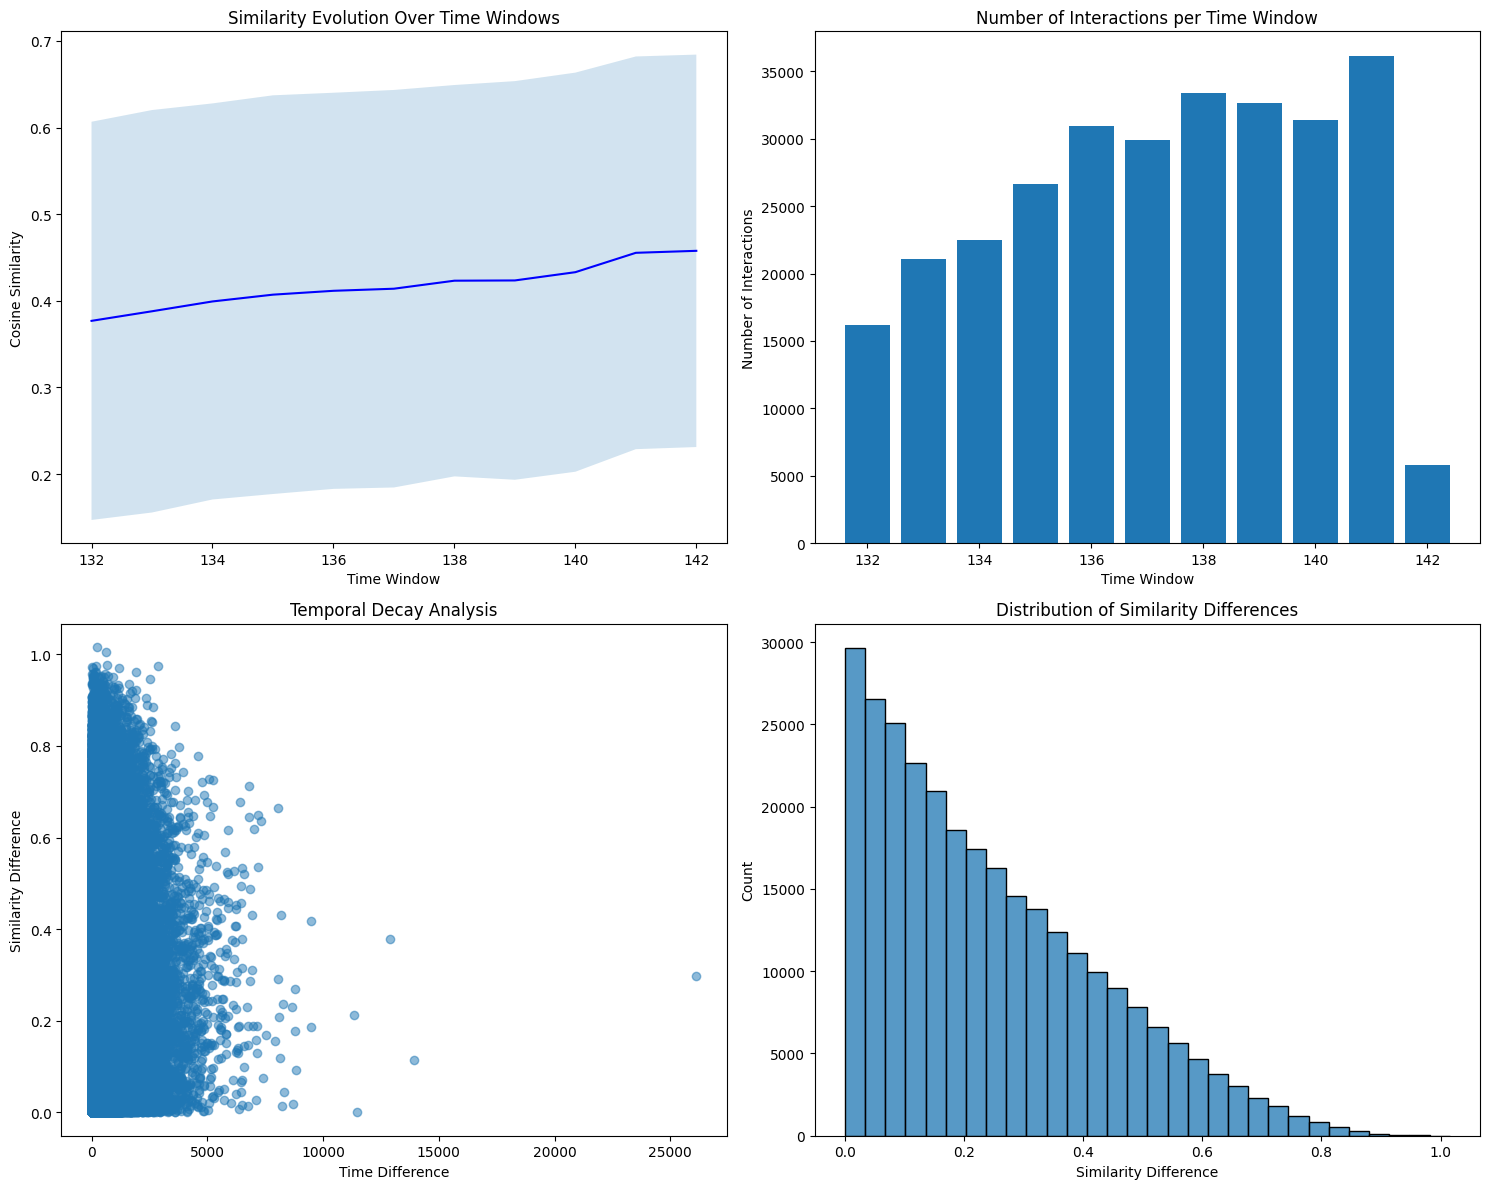

In [21]:
fig = plot_temporal_analysis(temporal_props['window_stats'], temporal_props['temporal_decay'])
plt.show()

In [13]:
import random
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import spearmanr, pearsonr

def validate_embeddings(embedding_dict, interaction_dict):
    random.seed(42)
    filtered_pairs = [(i, j) for i, j in interaction_dict.keys() if i != j]
    
    similarities = []
    interaction_strengths = []
    
    for i, j in filtered_pairs:
        sim = 1 - cosine(embedding_dict[i], embedding_dict[j])
        similarities.append(sim)
        
        interaction_strengths.append(interaction_dict[(i, j)])
    
    pearson_corr, _ = pearsonr(similarities, interaction_strengths)
    spearman_corr, _ = spearmanr(similarities, interaction_strengths)
    
    return similarities, interaction_strengths, pearson_corr, spearman_corr

In [14]:
distances, interaction_strengths, pearson_corr, spearman_corr = validate_embeddings(embedding_dict, interaction_dict)

In [15]:
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

Pearson Correlation: -0.014938629365279472
Spearman Correlation: -0.05079912688107641


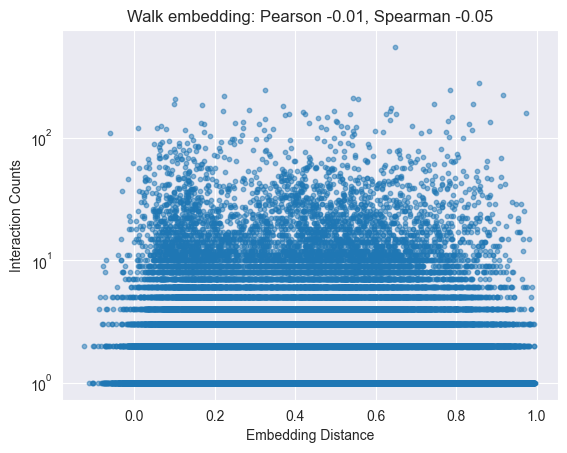

In [19]:
import matplotlib.pyplot as plt

plt.scatter(distances, interaction_strengths, alpha=0.5, s=10)
plt.title(f"Walk embedding: Pearson {pearson_corr:.2f}, Spearman {spearman_corr:.2f}")
plt.xlabel("Embedding Distance")
plt.ylabel("Interaction Counts")
plt.yscale('log')
plt.grid(True)
plt.savefig('plots/walk_embedding_skipgram.png')
plt.show()